In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from cv2 import GaussianBlur, bilateralFilter, filter2D
import numpy as np
from image_processing_helpers import *

In [2]:
# Setting
gen_img_idx = "1"
test_img_idx = gen_img_idx

epoch_round = 100
TAG = "_D02"
output_TAG = f"_{epoch_round}"
dataset_dir = './dataset_2_1'
output_dir = f"{dataset_dir}/post"
# output_dir = "./"

orig_image = cv2.imread(f"{dataset_dir}/test/{test_img_idx}.jpg")
# orig_image = cv2.imread('./denoised_image.png')
generated_image = cv2.imread(f"{dataset_dir}/generate/gen_image_{gen_img_idx}_epoch_{epoch_round}{TAG}.png")

In [ ]:
#5%-10%
def increase_saturation(image, inc=1.5):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    mask = hsv[:,:,1] * inc > 255
    s_channel = np.where(mask, 255, hsv[:,:,1] * inc)
    hsv[:,:,1] = s_channel
    back = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return back


In [5]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def sobel_xy(gray, sobel_kernel=3, absolute=True):
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    if absolute:
        sobel_x, sobel_y = np.absolute(sobel_x), np.absolute(sobel_y)
    return sobel_x, sobel_y

def gradient_magnitude(gray, sobel_kernel=3):
    return np.hypot(*sobel_xy(gray, sobel_kernel))

def gradient_direction(gray, sobel_kernel=3):
    return np.arctan2(*sobel_xy(gray, sobel_kernel))

def gradient_abs_sobel(gray, orient='x'):
    dx, dy = (1, 0) if orient == 'x' else (0, 1)
    sobel = cv2.Sobel(gray, cv2.CV_64F, dx, dy)
    return np.absolute(sobel)

def gradient_abs_sobel2(gray, orient='x'):
    orientation = {'x': 0,'y': 1}[orient]
    sobel = sobel_xy(gray)
    return sobel[orientation]

def scale(sobel, MAX=255, dtype=np.uint8):
    return dtype(MAX * sobel / np.max(sobel))

def mask(img, lower, upper):
    return (img >= lower) & (img <= upper)

In [6]:
# orig_image = cv2.imread("dball/test_image_2.jpg")
# generated_image = cv2.imread("dball/gen_image_2 (1).png")

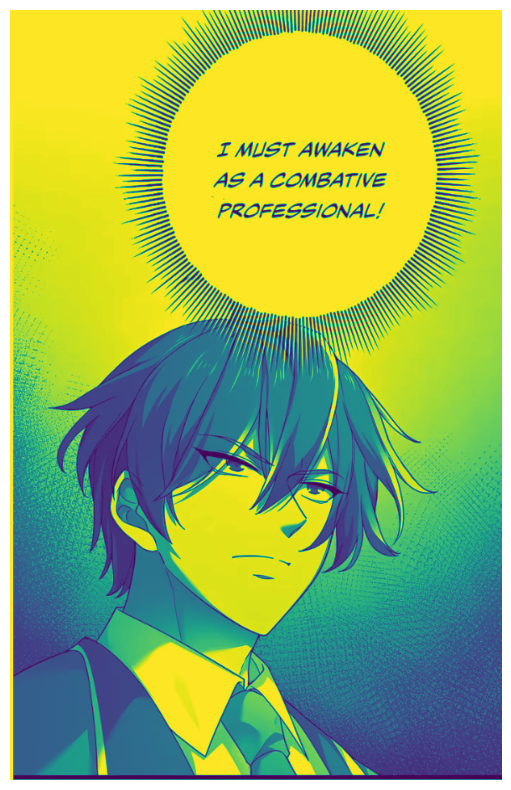

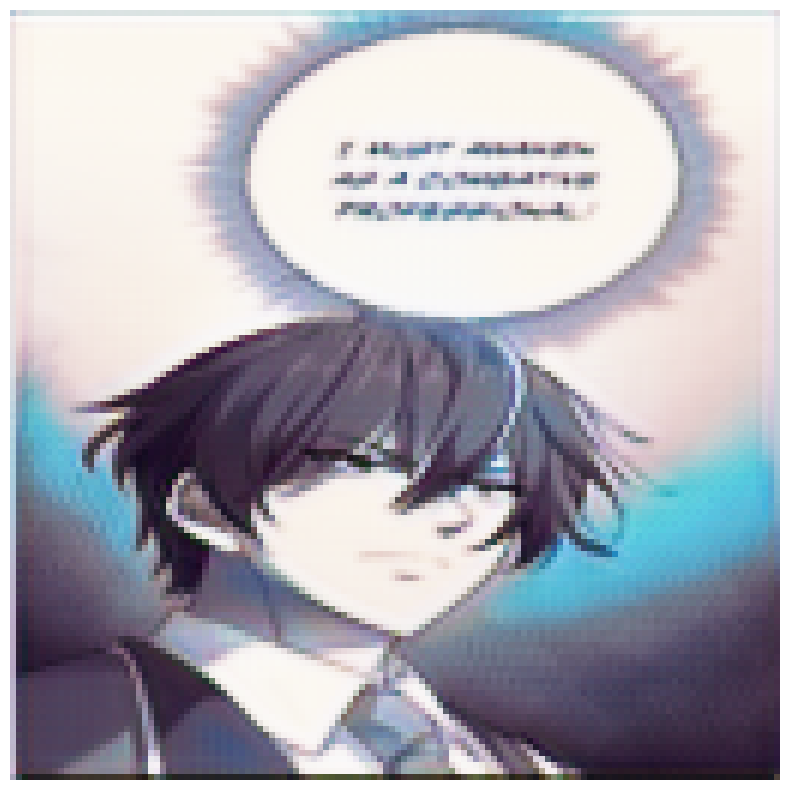

In [7]:
# get the gray scale image of the original image
gray_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2GRAY)
show_image(gray_image)
show_image(cv2.cvtColor(generated_image, cv2.COLOR_BGR2RGB))

In [8]:
# Smooth Image
kernel_radius = 2
smoothed_image = cv2.GaussianBlur(gray_image, (1+kernel_radius*2,1+kernel_radius*2), 0)

In [9]:
# get edges
abs_sobel = gradient_abs_sobel2(smoothed_image)
edges = mask(scale(abs_sobel), 8, 130)

In [10]:
dog=DifferenceOfGaussian(smoothed_image, 3)

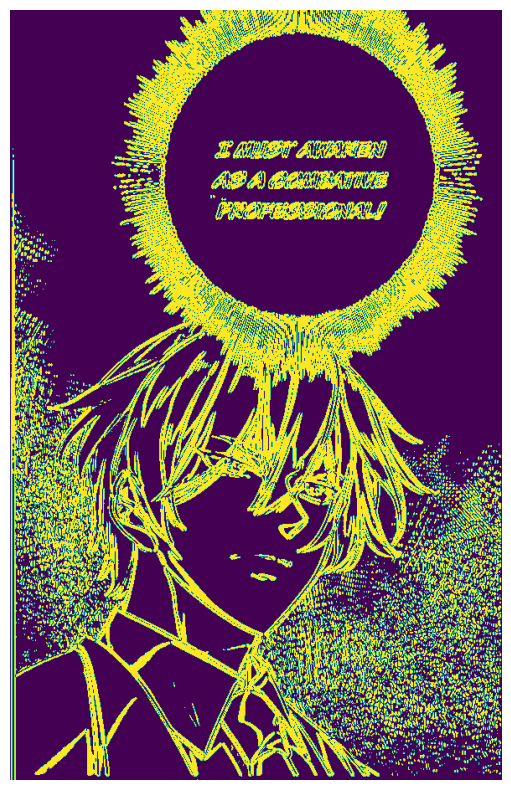

In [11]:
show_image(edges)

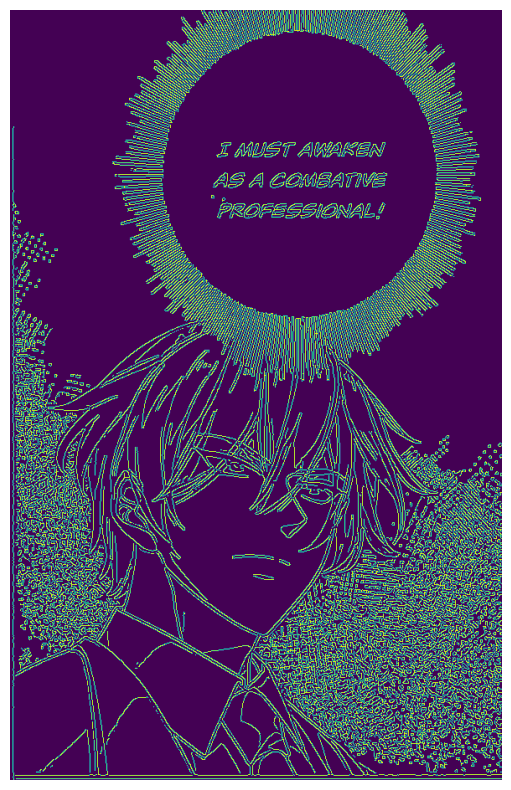

In [12]:
edges_2 = cv2.Canny(smoothed_image,10,40)
show_image(edges_2)

In [13]:
edges_3 = cv2.bitwise_or(edges_2, dog)

In [14]:
# get conneccted components
n, components = cv2.connectedComponents(edges_2, connectivity=8)

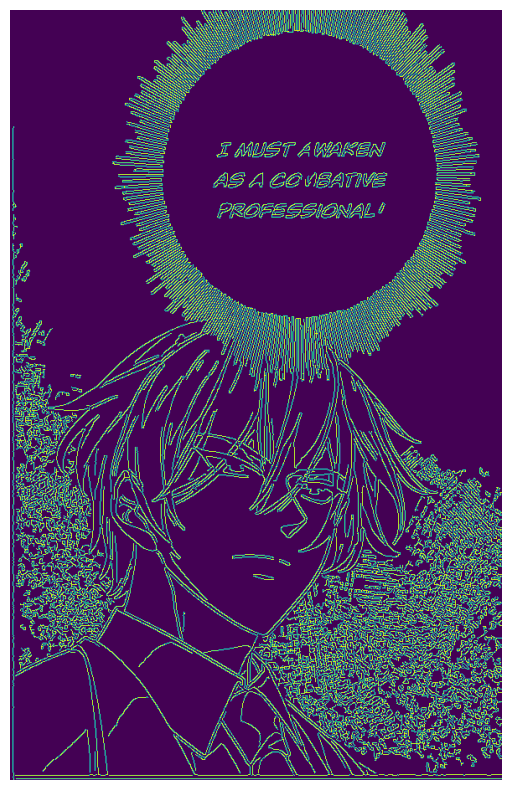

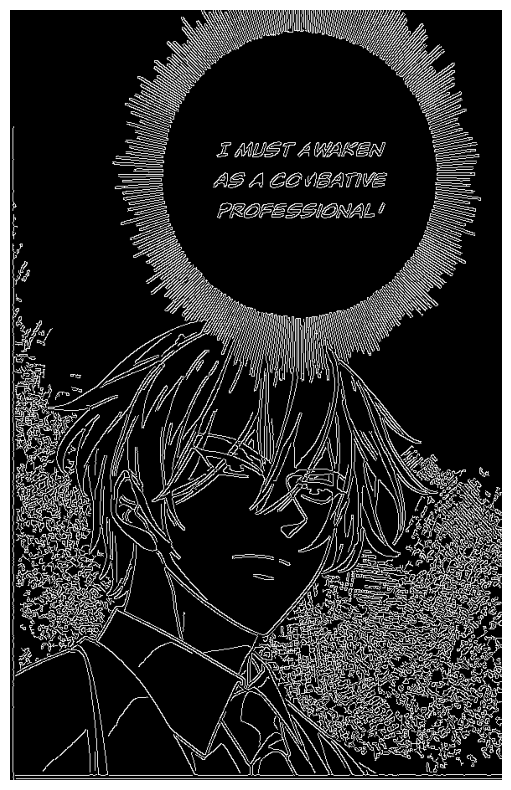

In [16]:
L = np.zeros(smoothed_image.shape,  np.uint8)
mask_ = np.array(components, dtype=np.uint8)#  
for label in range(1, n):
    
    if len(mask_[components == label]) > 20:
        mask_[components == label] = 255
        mask_[mask_ < 255] = 0
        L = cv2.bitwise_or(L, mask_)

show_image(L)
show_image(cv2.cvtColor(L, cv2.COLOR_BGR2RGB))



trapped-ball 15
trapped-ball 10
trapped-ball 9
trapped-ball 8
trapped-ball 7
trapped-ball 6
trapped-ball 5
trapped-ball 4
floodfill


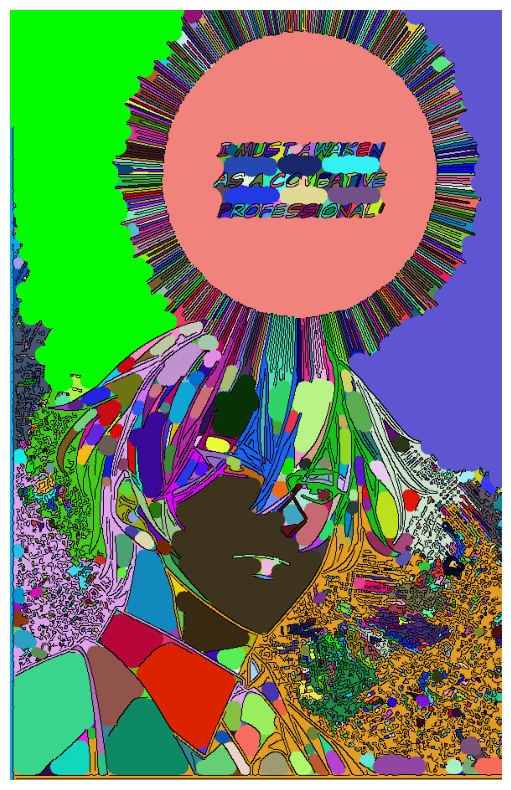

In [17]:
result = cv2.bitwise_not(L)
# result = cv2.imread('./final_line_drawing_mask.jpg', cv2.IMREAD_GRAYSCALE)

fills = []

fill = trapped_ball_fill_multi(result, 15, method="max")
fills += fill
result = mark_fill(result, fill)

for i in range(10,3, -1):
    fill = trapped_ball_fill_multi(result, i, method="mean")
    fills += fill
    result = mark_fill(result, fill)

fill = flood_fill_multi(result)
fills += fill

fillmap = build_fill_map(result, fills)

show_image(np.array(show_fill_map(fillmap), dtype=np.uint8))

merge 1
merge 2
merge 3


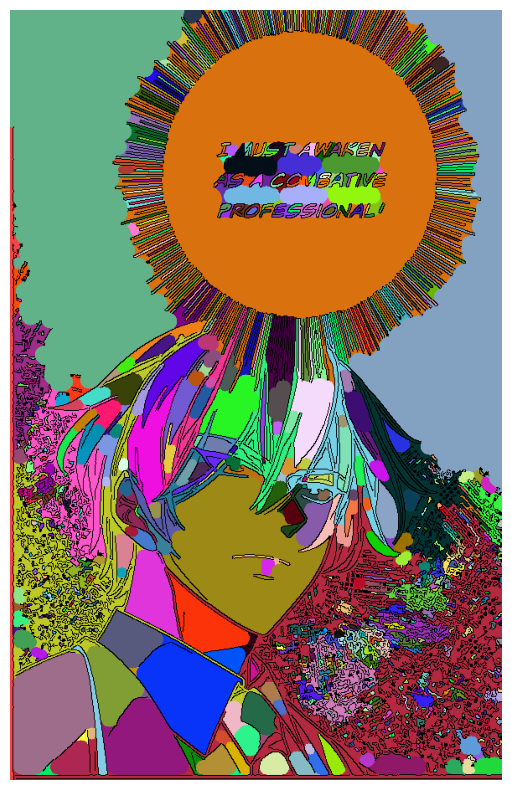

In [22]:
final=merge_fill(fillmap, max_iter=50)
show_image(np.array(show_fill_map(final), dtype=np.uint8))

In [23]:
h, w, d = orig_image.shape

In [24]:
generated_image = cv2.resize(generated_image, (w,h))

/tmp/ipykernel_302596/342087003.py:11: RuntimeWarning: invalid value encountered in cast
  blue_filter[blue_filter!=0] = np.mean(blue_filter[blue_filter != 0]).astype("int")
/tmp/ipykernel_302596/342087003.py:16: RuntimeWarning: invalid value encountered in cast
  green_filter[green_filter != 0] = np.mean(green_filter[green_filter != 0]).astype("int")
/tmp/ipykernel_302596/342087003.py:21: RuntimeWarning: invalid value encountered in cast
  red_filter[red_filter != 0] = np.mean(red_filter[red_filter != 0]).astype("int")


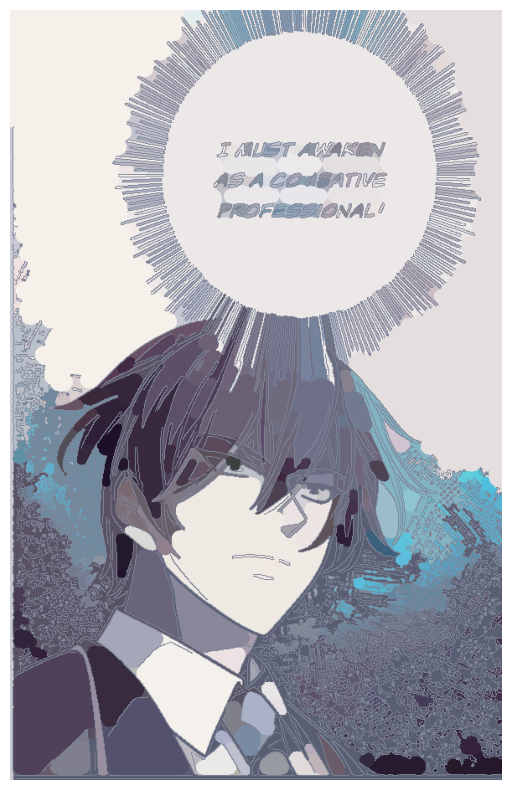

In [26]:
r,g,b = cv2.split(generated_image)

b_empty = np.zeros((h, w))
g_empty = np.zeros((h, w))
r_empty = np.zeros((h, w))

for i in range(np.max(final)):
    
    #blue
    blue_filter = (b * (final == i)).astype('int')
    blue_filter[blue_filter!=0] = np.mean(blue_filter[blue_filter != 0]).astype("int")
    b_empty += blue_filter
    
    #green
    green_filter = (g * (final == i)).astype('int')
    green_filter[green_filter != 0] = np.mean(green_filter[green_filter != 0]).astype("int")
    g_empty += green_filter
    
    #red
    red_filter = (r * (final == i)).astype('int')
    red_filter[red_filter != 0] = np.mean(red_filter[red_filter != 0]).astype("int")
    r_empty += red_filter
    
rgb = np.dstack((r_empty,g_empty,b_empty))
rgb=cv2.cvtColor(rgb.astype(np.uint8), cv2.COLOR_BGR2RGB)

show_image(rgb)


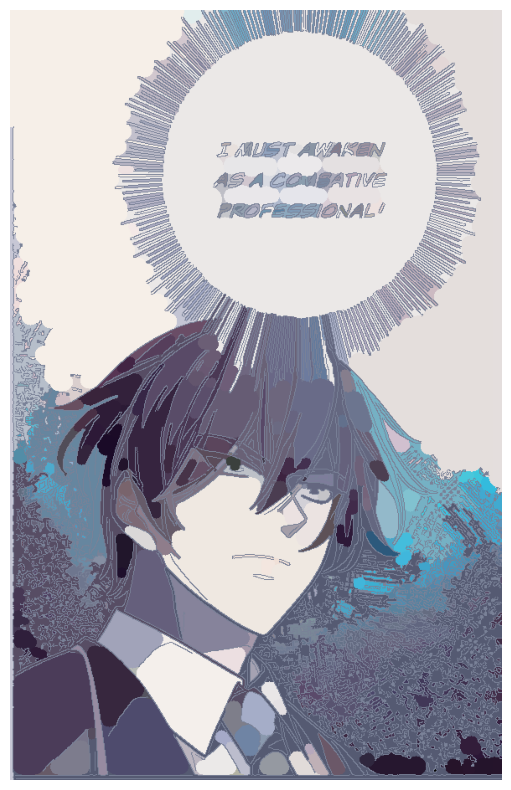

In [27]:
rgb_sat = increase_saturation(rgb.astype(np.uint8), inc=1.2)
show_image(rgb_sat)

In [28]:
import numpy as np

from sklearn import cluster

def quantize(raster, n_colors):
    width, height, depth = raster.shape
    reshaped_raster = np.reshape(raster, (width * height, depth))

    model = cluster.KMeans(n_clusters=n_colors)
    labels = model.fit_predict(reshaped_raster)
    palette = model.cluster_centers_

    quantized_raster = np.reshape(palette[labels], (width, height, palette.shape[1]))

    return quantized_raster

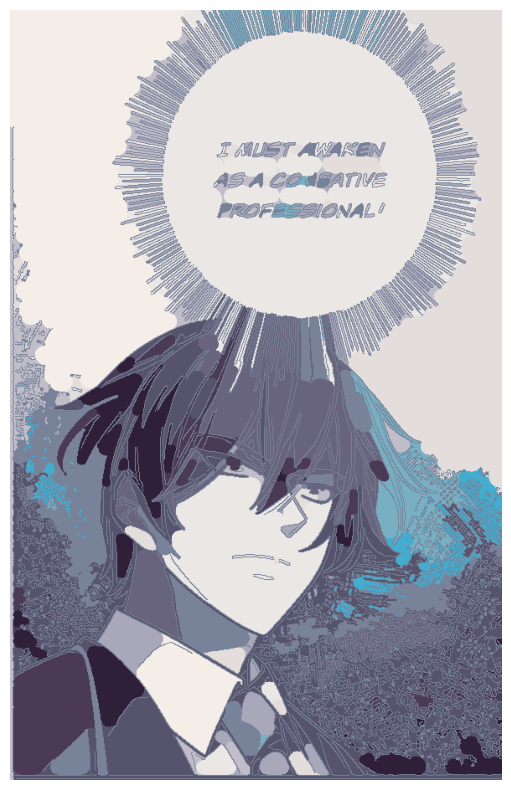

In [29]:
outs=quantize(rgb_sat, 12)
show_image(outs.astype(np.uint8))

245 31


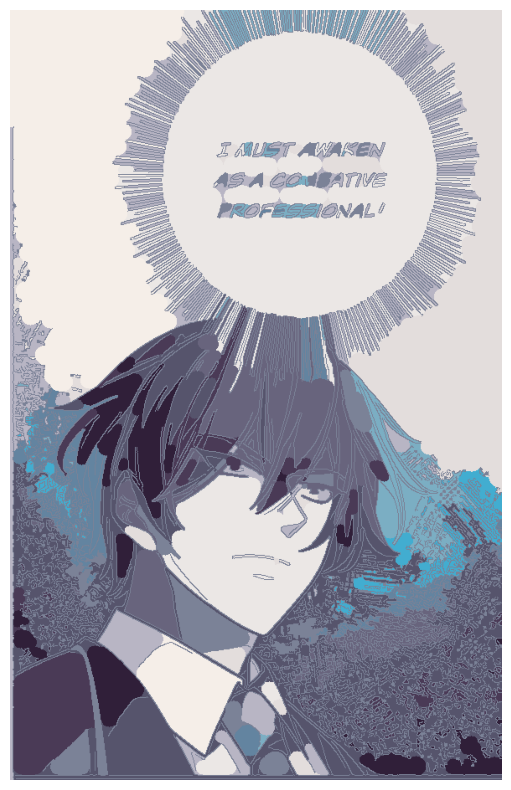

True

In [32]:
outs=quantize(rgb_sat, 12)
# print(outs.max())
# show_image(outs.astype(np.uint8))
outs = outs.astype(np.uint8)

# kernel_radius = kernel_radius+2 # two pixels bigger than the original kernel radius
# smoothed_image = cv2.GaussianBlur(gray_image, (1+kernel_radius*2,1+kernel_radius*2), 0)
# smoothed_image = np.stack((smoothed_image, smoothed_image, smoothed_image), axis=-1)

# outs = outs - ((255 - smoothed_image) / 3)
# outs[outs < 0] = 0
# outs = outs.astype(np.uint8)
print(outs.max(), outs.min())
show_image(outs)
cv2.imwrite(f'{output_dir}/{test_img_idx}{output_TAG}.jpg', cv2.cvtColor(outs, cv2.COLOR_RGB2BGR))
# cv2.imwrite(f'{output_dir}/{img_idx}.jpg', outs)
# plt.savefig(f'{output_dir}/{img_idx}.jpg')
